<h1 style="font-size:30px;">LeNet-5 with Batch Normalization</h1>

In this notebook, we add batch norm layers to the LeNet network, and see how it affects network training and convergence.

Instead of the MNIST dataset, which overfits easily, we will use the Fashion MNIST dataset.

<img src='https://opencv.org/wp-content/uploads/2023/05/c3_week3_lenet_batch_norm_feature_image.png' width=1500 align='center'><br/>

## Table of Contents

* [1 System Configuration](#1-System-Configuration)
* [2 Training Configuration](#2-Training-Configuration)
* [3 Dataset Processing](#3-Dataset-Processing)
* [4 Modeling LeNet5 with and without Batch Norm](#4-Modeling-LeNet5-with-and-without-Batch-Norm)
* [5 Training Pipeline](#5-Training-Pipeline)
* [6 Plot Training Results](#6-Plot-Training-Results)
* [7 Model Evaluation and Plotting Predictions](#7-Model-Evaluation-and-Plotting-Predictions)
* [8 Conclusion](#8-Conclusion)

In [ ]:
# Uncooment the line below, if you are using Colab.
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We shall first begin with our imports.

In [ ]:
import os
import random
import math
import numpy as np
import time
import copy

from tqdm import tqdm

import requests
from zipfile import ZipFile

from dataclasses import dataclass
from typing import List, Tuple, Union

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler

from torchvision import datasets, transforms as T
from torchvision.transforms import functional

from torchinfo import summary

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

%matplotlib inline

In [ ]:
bold = f"\033[1m"
reset = f"\033[0m"

## 1 System Configuration

We need to set the required seeds to make the results **reproducible**.

In [ ]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        
    
set_seeds()

## 2 Training Configuration

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 10
    IMG_HEIGHT:  int = 32
    IMG_WIDTH:   int = 32
    BATCH_SIZE:  int = 32
    NUM_WORKERS: int = 2
    DATA_ROOT:   str = "DATA_FASHION_MNIST"
        
        
@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:         int   = 20
    LEARNING_RATE:  float = 1e-2
    CHECKPOINT_DIR: str   = "DATA_FASHION_MNIST_CHECKPOINTS"
    DEVICE:         str   = "cuda"

For training on `cpu`, you san set the following configurations:

- **`TrainingConfig`**:
  * `DEVICE = "cpu"`

## 3 Dataset Processing

We will use the Fashion MNIST dataset for our experiment.

<img src='https://opencv.org/wp-content/uploads/2023/05/c3_week3_MNIST_fashion.png' width=650 align='center'>

There are 10 classes. Each training and testing example is assigned to one of the following labels:

|Label| Description |
|:------:|:--------|
|0	|T-shirt/top|
|1	|Trouser|
|2	|Pullover|
|3	|Dress|
|4	|Coat|
|5	|Sandal|
|6	|Shirt|
|7	|Sneaker|
|8	|Bag|
|9	|Ankle boot|


### 3.1 Define Preprocessing Transforms

Before we start for preparing our dataset, it is essential to resize our data to some fixed dimensions. The `image_preprocess_transforms` resizes the image data to a shape of `(32, 32)` and converts them to a tensor which normalizes the image data in the range `[0., 1.]`. Besides, it also transposes the dimensions from `[H, W, C]` to `[C, H, W]`.

Finally the image data needs to be **normalized** again, using the appropriate mean and standard deviation. 

In other words, following equation is used for Normalization across each image channel, $C$:

$$ \hat x_C = \frac{x_C - \mu_C}{\sigma_C}$$

For Fashion MNIST, we only have have a single channel. Its **mean** and **standard deviation** have already been computed, and turns out to be `[0.2860,]` and `[0.3530,]` respectively.

In [ ]:
def image_preprocess_transforms(img_size: Tuple[int] = (32,32)):
    
    preprocess = T.Compose([
                    # Resize image data to img_size.
                    T.Resize(img_size, antialias=True),
                    # Convert (H,W,C) to (C,H,W) and normalize data to [0., 1.].
                    # by dividing with 255.
                    T.ToTensor(),
                    # Subtract mean (0.1307) and divide by variance (0.3081).
                    # This mean and variance is calculated on training data.
                    T.Normalize(mean=[0.2860,], std=[0.3530,])
                 ])
    
    return preprocess

### 3.2 Create the Train and ValidationTest Data Loaders

In [ ]:
def get_data(root_dir, img_size, batch_size, num_workers=1):
    
    train_test_transforms = image_preprocess_transforms(img_size)
    
    if os.path.exists(root_dir):
        download = False
    else:
        download = True
    
    train_dataset = datasets.FashionMNIST(
                            root=root_dir,
                            download=download,
                            train=True,
                            transform=train_test_transforms
                        )
    
    valid_dataset = datasets.FashionMNIST(
                            root=root_dir,
                            download=download,
                            train=False,
                            transform=train_test_transforms
                        )              
    
    # Train dataloader
    train_loader = DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=num_workers
                    )
    # Validation loader
    valid_loader = DataLoader(
                        valid_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)
    
   
    
    return train_loader, valid_loader

### 3.3 Data Visualization

Let us now display a few samples from the validation data. We will initialize the `image_size`, `batch_size`, the dataset directory, and the workers here.

In [ ]:
def visualize_samples(data_loader, classes):
    
    plt.figure(figsize=(18, 8))
    
    image_batch, target_batch = next(iter(data_loader))
    
    for i, (image, target) in enumerate(zip(image_batch, target_batch)):
        
        if i>=10:
            break
            
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(r"$\bf{"+classes[target]+"}$")
        plt.axis("off")
                
    plt.suptitle('Dataset Samples', fontsize=18)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show(block=block_plot)
    plt.close()

In [ ]:
data_config = DatasetConfig()
# Download the FashionMNIST dataset.
train_loader, _ = get_data(
                       root_dir=data_config.DATA_ROOT,
                       img_size=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH),
                       batch_size=data_config.BATCH_SIZE,
                       num_workers=data_config.NUM_WORKERS)

100%|██████████| 26421880/26421880 [00:01<00:00, 15622503.08it/s]


Extracting DATA_FASHION_MNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to DATA_FASHION_MNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273247.12it/s]


Extracting DATA_FASHION_MNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to DATA_FASHION_MNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5032513.39it/s]


Extracting DATA_FASHION_MNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to DATA_FASHION_MNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7178283.57it/s]

Extracting DATA_FASHION_MNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_FASHION_MNIST/FashionMNIST/raw



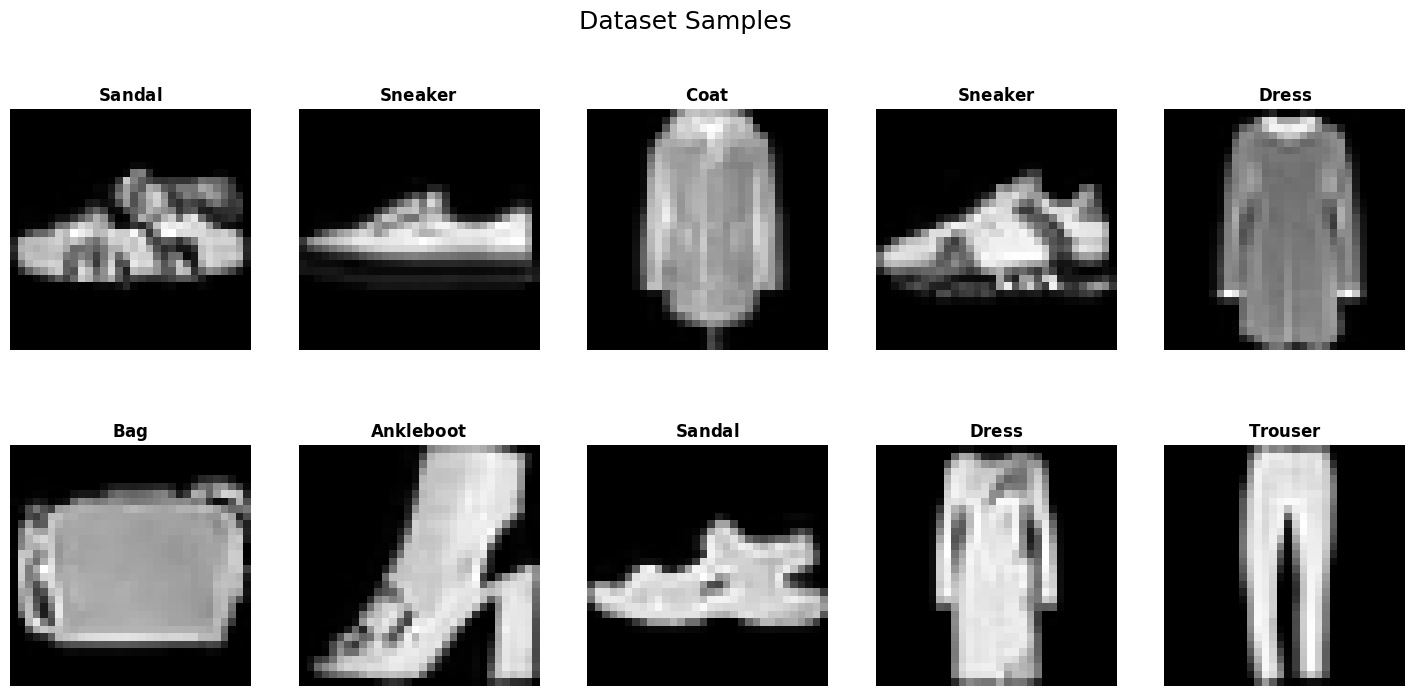

In [ ]:
class_names = train_loader.dataset.classes
visualize_samples(train_loader, class_names)

## 4 Modeling LeNet5 with and without Batch Norm

This network has two convolutional layers and three fully connected layers. The model architecture can be then divided into two parts:


1. **`_body`**: This implements the Convolutional part of the network, which consists of the two convolutional layers. Each convolutional layer is followed by a pooling layer. In classical Machine Learning terms, it also works as a feature extractor.
2. **`_head`**: This implements the fully-connected part of the network. It consists of three fully-connected layers, with the last layer having ten output classes.

Since we would be implementing Batch Norm to our model, there is an additional flag: `batch_norm` in the `init` to enable batch norm. 

When `batch_norm` is enabled, we have applied the [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) module after the `Conv` layer and before the `ReLU` activation.

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes, batch_norm=False):
        super().__init__()
        
        # convolution layers
        
        if batch_norm:
            self._body = nn.Sequential(
                # First convolution Layer
                # input size = (32, 32), output size = (28, 28)
                nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
                nn.BatchNorm2d(6),
                # ReLU activation
                nn.ReLU(inplace=True),
                # Max pool 2-d
                nn.MaxPool2d(kernel_size=2),

                # Second convolution layer
                # input size = (14, 14), output size = (10, 10)
                nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                # output size = (5, 5)
            )
          
        
        else:
            self._body = nn.Sequential(
                # First convolution Layer
                # input size = (32, 32), output size = (28, 28)
                nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
                # ReLU activation
                nn.ReLU(inplace=True),
                # Max pool 2-d
                nn.MaxPool2d(kernel_size=2),

                # Second convolution layer
                # input size = (14, 14), output size = (10, 10)
                nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                # output size = (5, 5)
            )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weights in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # Third fully connected layer. It is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=num_classes)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.shape[0], -1)
        # apply classification head
        x = self._head(x)
        return x

## 5 Training Pipeline

The `create_checkpoint_dir` utility function creates the specified directory to save the model with the best weights.

In [ ]:
def create_checkpoint_dir(checkpoint_dir):
    
    # Create a new checkpoint directory every time.
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    print(f"Checkpoint directory: {checkpoint_dir}")
    return checkpoint_dir

### 5.1 Define Train Step

The `train` function defines the training steps for model. This is where the model weights are updated  using backprop. We shall also print the loss and the accuracy for each epoch as the training progresses.

In [ ]:
def train(
    train_config: TrainingConfig,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int
) -> Tuple[float, float]:
    
    # change model in training mode
    model.train()
    
    count_sample = 0
    step_loss = 0
    step_accuracy = 0
    
    status = f"Train:\t{bold}Epoch: {epoch_idx}/{total_epochs}{reset}"
    
    prog_bar = tqdm(train_loader, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    
    prog_bar.set_description(status)
     
    for data, target in prog_bar:

        # Send data and target to appropriate device.
        data, target = data.to(train_config.DEVICE), target.to(train_config.DEVICE)

        # Reset parameters gradient to zero.
        optimizer.zero_grad()

        # Forward pass to the model.
        output = model(data)

        # Cross Entropy loss
        loss = F.cross_entropy(output, target)

        # Find gradients w.r.t training parameters.
        loss.backward()

        # Update parameters using gradients.
        optimizer.step()

        # Get probability score using softmax.
        prob = F.softmax(output, dim=1)

        # Get the index of the max probability.
        pred_idx = prob.detach().argmax(dim=1)
        
        # Batch Loss.
        step_loss+= loss.item() * data.shape[0]

        # Batch accuracy.
        step_accuracy+= (pred_idx.cpu() == target.cpu()).sum()
        
        # Count samples.
        count_sample+= data.shape[0]

        # Update progress bar description.
        step_status = status + f"\tLoss: {float(step_loss/count_sample):.4f}, "
        step_status+= f"Acc: {float(step_accuracy/count_sample):.4f}"
        prog_bar.set_description(step_status)

    epoch_loss = float(step_loss / len(train_loader.dataset))
    epoch_acc = float(step_accuracy/ len(train_loader.dataset))
    
    prog_bar.close()
    
    return epoch_loss, epoch_acc

### 5.2 Define Validation Step

The `validate` function is used to calculate the validation loss and accuracy for each epoch.

In [ ]:
def validate(
    train_config: TrainingConfig,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int
) -> Tuple[float, float]:
    # 
    model.eval()
    
    count_sample = 0
    step_loss = 0
    step_accuracy = 0
    
    status = f"Valid:\t{bold}Epoch: {epoch_idx}/{total_epochs}{reset}"
    
    prog_bar = tqdm(test_loader, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    
    prog_bar.set_description(status)
       
    for data, target in prog_bar:

        # Send data and target to appropriate device.
        data, target = data.to(train_config.DEVICE), target.to(train_config.DEVICE)

        # Get the model's predicted logits.
        with torch.no_grad():
            output = model(data)

        # Compute the CE-Loss.
        test_loss = F.cross_entropy(output, target).item()

        # Convert model's logits to probability scores.
        prob = F.softmax(output, dim=1)

        # Get the class id for the maximum score.
        pred_idx = prob.detach().argmax(dim=1)

        # Batch validation loss.
        step_loss+= test_loss * data.shape[0]

        # Batch validation accuracy.
        step_accuracy+= (pred_idx.cpu() == target.cpu()).sum()
        
        # Count samples.
        count_sample+= data.shape[0]

        # Update progress bar description.
        step_status = status + f"\tLoss: {float(step_loss/count_sample):.4f}, "
        step_status+= f"Acc: {float(step_accuracy/count_sample):.4f}"
        prog_bar.set_description(step_status)


    test_loss = float(step_loss / len(test_loader.dataset))
    test_acc = float(step_accuracy/ len(test_loader.dataset)) 
    
    prog_bar.close()
  
    return test_loss, test_acc

### 5.3 Perform Training

The final step is to perform the training and add save the model checkpoints with the best validation loss.

In [ ]:
def main(
     model: nn.Module,
     optimizer: Union[optim.SGD, optim.Adam],
     ckpt_dir: str,
     data_config: DatasetConfig,
     train_config: TrainingConfig,
     model_name: str,
  ) -> dict:
    
    
    # data loader      
    train_loader, valid_loader = get_data(
                                     root_dir=data_config.DATA_ROOT,
                                     img_size=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH),
                                     batch_size=data_config.BATCH_SIZE,
                                     num_workers=data_config.NUM_WORKERS
                                    )
    
    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = []
    epoch_test_loss = []
    
    # epoch train/test accuracy
    epoch_train_acc = []
    epoch_test_acc = []
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(train_config.EPOCHS):
        
        train_loss, train_acc = train(train_config, model,
                                      optimizer, train_loader, epoch+1, train_config.EPOCHS)
        val_loss, val_accuracy = validate(train_config, model,
                                          valid_loader, epoch+1, train_config.EPOCHS)
        
        train_loss_stat = f"{bold}Train Loss: {train_loss:.4f}{reset}"
        train_acc_stat = f"{bold}Train Acc: {train_acc:.4f}{reset}"

        val_loss_stat = f"{bold}Val Loss: {val_loss:.4f}{reset}"
        val_acc_stat = f"{bold}Val Acc: {val_accuracy:.4f}{reset}"
                                        
        print(f"\n{train_loss_stat:<30}{train_acc_stat}")
        print(f"{val_loss_stat:<30}{val_acc_stat}")
        
        
        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)

        epoch_test_loss.append(val_loss)
        epoch_test_acc.append(val_accuracy)
        

        if val_loss < best_loss:
            best_loss = val_loss
            print(f"\nModel Improved... Saving Model ... ", end="")
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), os.path.join(ckpt_dir, model_name))
            print("Done.\n")
        
        print(f"{'='*72}\n")
                
    print(f"Total time: {(time.time() - t_begin):.2f}s, Best Loss: {best_loss:.3f}")
    
    # Load model with best weights.
    model.load_state_dict(best_weights)
    
    history = dict(
                    model = model,
                    train_loss = epoch_train_loss,
                    train_acc = epoch_train_acc,
                    valid_loss = epoch_test_loss,
                    valid_acc = epoch_test_acc,
                    train_config = train_config,
                    data_config = data_config
                  )
    
    return history

### 5.4 Model Checkpoints

We shall create the checkpoint directory to save our model.

In [ ]:
CKPT_DIR = create_checkpoint_dir(TrainingConfig.CHECKPOINT_DIR)

# Instantiate `TrainingConfig` and `DatasetConfig`.
train_config = TrainingConfig()
dataset_config = DatasetConfig()

Checkpoint directory: DATA_FASHION_MNIST_CHECKPOINTS


Now, lets create our model. We shall also print its summary. We have also defined our optimizer in this code cell.

In [ ]:
lenet_model = LeNet5(num_classes=dataset_config.NUM_CLASSES)

print(summary(lenet_model,
              input_size=(1, 1, dataset_config.IMG_HEIGHT, dataset_config.IMG_WIDTH),
              row_settings=["var_names"])) 

lenet_model = lenet_model.float().to(train_config.DEVICE)

optimizer = optim.SGD(
                        lenet_model.parameters(),
                        lr=train_config.LEARNING_RATE,
                      )


Layer (type (var_name))                  Output Shape              Param #
LeNet5 (LeNet5)                          [1, 10]                   --
├─Sequential (_body)                     [1, 16, 5, 5]             --
│    └─Conv2d (0)                        [1, 6, 28, 28]            156
│    └─ReLU (1)                          [1, 6, 28, 28]            --
│    └─MaxPool2d (2)                     [1, 6, 14, 14]            --
│    └─Conv2d (3)                        [1, 16, 10, 10]           2,416
│    └─ReLU (4)                          [1, 16, 10, 10]           --
│    └─MaxPool2d (5)                     [1, 16, 5, 5]             --
├─Sequential (_head)                     [1, 10]                   --
│    └─Linear (0)                        [1, 120]                  48,120
│    └─ReLU (1)                          [1, 120]                  --
│    └─Linear (2)                        [1, 84]                   10,164
│    └─ReLU (3)                          [1, 84]                   --
│  

Next we start our model training by calling the `main` function. We will run the experiment without Batch Norm first.

In [ ]:
history = main(
            model = lenet_model,
            optimizer = optimizer,
            ckpt_dir = CKPT_DIR,
            data_config = dataset_config,
            train_config = train_config,
            model_name="LeNet5_FASHION_MNIST.pth"
            
            )


Valid:	Epoch: 1/20	Loss: 0.6414, Acc: 0.7515: 100%|██████████| 313/313 [00:01<00:00, 159.35it/s]



Train Loss: 1.0176    Train Acc: 0.6295
Val Loss: 0.6414      Val Acc: 0.7515

Model Improved... Saving Model ... Done.




Valid:	Epoch: 2/20	Loss: 0.5096, Acc: 0.8136: 100%|██████████| 313/313 [00:01<00:00, 159.28it/s]



Train Loss: 0.5406    Train Acc: 0.7964
Val Loss: 0.5096      Val Acc: 0.8136

Model Improved... Saving Model ... Done.




Valid:	Epoch: 3/20	Loss: 0.4393, Acc: 0.8433: 100%|██████████| 313/313 [00:02<00:00, 152.69it/s]



Train Loss: 0.4543    Train Acc: 0.8311
Val Loss: 0.4393      Val Acc: 0.8433

Model Improved... Saving Model ... Done.




Valid:	Epoch: 4/20	Loss: 0.4841, Acc: 0.8152: 100%|██████████| 313/313 [00:01<00:00, 160.72it/s]



Train Loss: 0.4080    Train Acc: 0.8491
Val Loss: 0.4841      Val Acc: 0.8152



Valid:	Epoch: 5/20	Loss: 0.3954, Acc: 0.8588: 100%|██████████| 313/313 [00:01<00:00, 159.70it/s]



Train Loss: 0.3751    Train Acc: 0.8624
Val Loss: 0.3954      Val Acc: 0.8588

Model Improved... Saving Model ... Done.




Valid:	Epoch: 6/20	Loss: 0.3638, Acc: 0.8676: 100%|██████████| 313/313 [00:01<00:00, 158.54it/s]



Train Loss: 0.3528    Train Acc: 0.8696
Val Loss: 0.3638      Val Acc: 0.8676

Model Improved... Saving Model ... Done.




Valid:	Epoch: 7/20	Loss: 0.3537, Acc: 0.8728: 100%|██████████| 313/313 [00:01<00:00, 161.61it/s]



Train Loss: 0.3338    Train Acc: 0.8777
Val Loss: 0.3537      Val Acc: 0.8728

Model Improved... Saving Model ... Done.




Valid:	Epoch: 8/20	Loss: 0.3604, Acc: 0.8678: 100%|██████████| 313/313 [00:01<00:00, 158.75it/s]



Train Loss: 0.3194    Train Acc: 0.8820
Val Loss: 0.3604      Val Acc: 0.8678



Valid:	Epoch: 9/20	Loss: 0.3377, Acc: 0.8771: 100%|██████████| 313/313 [00:02<00:00, 154.42it/s]



Train Loss: 0.3053    Train Acc: 0.8873
Val Loss: 0.3377      Val Acc: 0.8771

Model Improved... Saving Model ... Done.




Valid:	Epoch: 10/20	Loss: 0.3274, Acc: 0.8819: 100%|██████████| 313/313 [00:01<00:00, 157.79it/s]



Train Loss: 0.2940    Train Acc: 0.8909
Val Loss: 0.3274      Val Acc: 0.8819

Model Improved... Saving Model ... Done.




Valid:	Epoch: 11/20	Loss: 0.3337, Acc: 0.8789: 100%|██████████| 313/313 [00:01<00:00, 162.78it/s]



Train Loss: 0.2856    Train Acc: 0.8941
Val Loss: 0.3337      Val Acc: 0.8789



Valid:	Epoch: 12/20	Loss: 0.3410, Acc: 0.8701: 100%|██████████| 313/313 [00:01<00:00, 158.29it/s]



Train Loss: 0.2756    Train Acc: 0.8983
Val Loss: 0.3410      Val Acc: 0.8701



Valid:	Epoch: 13/20	Loss: 0.3223, Acc: 0.8838: 100%|██████████| 313/313 [00:01<00:00, 160.11it/s]



Train Loss: 0.2681    Train Acc: 0.9004
Val Loss: 0.3223      Val Acc: 0.8838

Model Improved... Saving Model ... Done.




Valid:	Epoch: 14/20	Loss: 0.3078, Acc: 0.8868: 100%|██████████| 313/313 [00:01<00:00, 162.10it/s]



Train Loss: 0.2599    Train Acc: 0.9048
Val Loss: 0.3078      Val Acc: 0.8868

Model Improved... Saving Model ... Done.




Valid:	Epoch: 15/20	Loss: 0.2956, Acc: 0.8929: 100%|██████████| 313/313 [00:01<00:00, 160.12it/s]



Train Loss: 0.2541    Train Acc: 0.9049
Val Loss: 0.2956      Val Acc: 0.8929

Model Improved... Saving Model ... Done.




Valid:	Epoch: 16/20	Loss: 0.2919, Acc: 0.8930: 100%|██████████| 313/313 [00:02<00:00, 153.24it/s]



Train Loss: 0.2485    Train Acc: 0.9074
Val Loss: 0.2919      Val Acc: 0.8930

Model Improved... Saving Model ... Done.




Valid:	Epoch: 17/20	Loss: 0.2956, Acc: 0.8929: 100%|██████████| 313/313 [00:02<00:00, 155.45it/s]



Train Loss: 0.2421    Train Acc: 0.9099
Val Loss: 0.2956      Val Acc: 0.8929



Valid:	Epoch: 18/20	Loss: 0.2962, Acc: 0.8917: 100%|██████████| 313/313 [00:01<00:00, 159.39it/s]



Train Loss: 0.2359    Train Acc: 0.9127
Val Loss: 0.2962      Val Acc: 0.8917



Valid:	Epoch: 19/20	Loss: 0.3158, Acc: 0.8826: 100%|██████████| 313/313 [00:01<00:00, 160.56it/s]



Train Loss: 0.2299    Train Acc: 0.9143
Val Loss: 0.3158      Val Acc: 0.8826



Valid:	Epoch: 20/20	Loss: 0.2811, Acc: 0.8978: 100%|██████████| 313/313 [00:01<00:00, 163.29it/s]



Train Loss: 0.2253    Train Acc: 0.9157
Val Loss: 0.2811      Val Acc: 0.8978

Model Improved... Saving Model ... Done.


Total time: 266.15s, Best Loss: 0.281


Now, let's run our experiment again with **Batch Norm** enabled.

In [ ]:
lenet_bn = LeNet5(num_classes=dataset_config.NUM_CLASSES, batch_norm=True)

print(summary(lenet_bn,
              input_size=(1, 1, dataset_config.IMG_HEIGHT, dataset_config.IMG_WIDTH),
              row_settings=["var_names"])) 

lenet_bn = lenet_bn.float().to(train_config.DEVICE)

optimizer = optim.SGD(
                        lenet_bn.parameters(),
                        lr=train_config.LEARNING_RATE,
                      )


Layer (type (var_name))                  Output Shape              Param #
LeNet5 (LeNet5)                          [1, 10]                   --
├─Sequential (_body)                     [1, 16, 5, 5]             --
│    └─Conv2d (0)                        [1, 6, 28, 28]            156
│    └─BatchNorm2d (1)                   [1, 6, 28, 28]            12
│    └─ReLU (2)                          [1, 6, 28, 28]            --
│    └─MaxPool2d (3)                     [1, 6, 14, 14]            --
│    └─Conv2d (4)                        [1, 16, 10, 10]           2,416
│    └─BatchNorm2d (5)                   [1, 16, 10, 10]           32
│    └─ReLU (6)                          [1, 16, 10, 10]           --
│    └─MaxPool2d (7)                     [1, 16, 5, 5]             --
├─Sequential (_head)                     [1, 10]                   --
│    └─Linear (0)                        [1, 120]                  48,120
│    └─ReLU (1)                          [1, 120]                  --
│    └─

In [ ]:
history_batch_norm = main(
                        model = lenet_bn,
                        optimizer = optimizer,
                        ckpt_dir = CKPT_DIR,
                        data_config = dataset_config,
                        train_config = train_config,
                        model_name="LeNet5_BN_FASHION_MNIST.pth"
                    )

Valid:	Epoch: 1/20	Loss: 0.5025, Acc: 0.8127: 100%|██████████| 313/313 [00:01<00:00, 160.97it/s]



Train Loss: 0.7251    Train Acc: 0.7552
Val Loss: 0.5025      Val Acc: 0.8127

Model Improved... Saving Model ... Done.




Valid:	Epoch: 2/20	Loss: 0.4116, Acc: 0.8483: 100%|██████████| 313/313 [00:01<00:00, 159.32it/s]



Train Loss: 0.4034    Train Acc: 0.8546
Val Loss: 0.4116      Val Acc: 0.8483

Model Improved... Saving Model ... Done.




Valid:	Epoch: 3/20	Loss: 0.3636, Acc: 0.8648: 100%|██████████| 313/313 [00:01<00:00, 160.58it/s]



Train Loss: 0.3549    Train Acc: 0.8715
Val Loss: 0.3636      Val Acc: 0.8648

Model Improved... Saving Model ... Done.




Valid:	Epoch: 4/20	Loss: 0.3565, Acc: 0.8691: 100%|██████████| 313/313 [00:01<00:00, 158.57it/s]



Train Loss: 0.3265    Train Acc: 0.8815
Val Loss: 0.3565      Val Acc: 0.8691

Model Improved... Saving Model ... Done.




Valid:	Epoch: 5/20	Loss: 0.3354, Acc: 0.8798: 100%|██████████| 313/313 [00:01<00:00, 162.24it/s]



Train Loss: 0.3070    Train Acc: 0.8886
Val Loss: 0.3354      Val Acc: 0.8798

Model Improved... Saving Model ... Done.




Valid:	Epoch: 6/20	Loss: 0.3462, Acc: 0.8720: 100%|██████████| 313/313 [00:01<00:00, 162.07it/s]



Train Loss: 0.2933    Train Acc: 0.8933
Val Loss: 0.3462      Val Acc: 0.8720



Valid:	Epoch: 7/20	Loss: 0.3085, Acc: 0.8868: 100%|██████████| 313/313 [00:01<00:00, 164.58it/s]



Train Loss: 0.2802    Train Acc: 0.8988
Val Loss: 0.3085      Val Acc: 0.8868

Model Improved... Saving Model ... Done.




Valid:	Epoch: 8/20	Loss: 0.3096, Acc: 0.8877: 100%|██████████| 313/313 [00:01<00:00, 163.63it/s]



Train Loss: 0.2698    Train Acc: 0.9018
Val Loss: 0.3096      Val Acc: 0.8877



Valid:	Epoch: 9/20	Loss: 0.3120, Acc: 0.8854: 100%|██████████| 313/313 [00:01<00:00, 171.02it/s]



Train Loss: 0.2600    Train Acc: 0.9050
Val Loss: 0.3120      Val Acc: 0.8854



Valid:	Epoch: 10/20	Loss: 0.2924, Acc: 0.8958: 100%|██████████| 313/313 [00:01<00:00, 156.81it/s]



Train Loss: 0.2521    Train Acc: 0.9079
Val Loss: 0.2924      Val Acc: 0.8958

Model Improved... Saving Model ... Done.




Valid:	Epoch: 11/20	Loss: 0.2815, Acc: 0.9002: 100%|██████████| 313/313 [00:01<00:00, 160.07it/s]



Train Loss: 0.2446    Train Acc: 0.9104
Val Loss: 0.2815      Val Acc: 0.9002

Model Improved... Saving Model ... Done.




Valid:	Epoch: 12/20	Loss: 0.2926, Acc: 0.8951: 100%|██████████| 313/313 [00:02<00:00, 155.97it/s]



Train Loss: 0.2382    Train Acc: 0.9116
Val Loss: 0.2926      Val Acc: 0.8951



Valid:	Epoch: 13/20	Loss: 0.2769, Acc: 0.8997: 100%|██████████| 313/313 [00:01<00:00, 159.45it/s]



Train Loss: 0.2314    Train Acc: 0.9151
Val Loss: 0.2769      Val Acc: 0.8997

Model Improved... Saving Model ... Done.




Valid:	Epoch: 14/20	Loss: 0.2759, Acc: 0.9004: 100%|██████████| 313/313 [00:01<00:00, 157.57it/s]



Train Loss: 0.2252    Train Acc: 0.9166
Val Loss: 0.2759      Val Acc: 0.9004

Model Improved... Saving Model ... Done.




Valid:	Epoch: 15/20	Loss: 0.2816, Acc: 0.8973: 100%|██████████| 313/313 [00:01<00:00, 159.68it/s]



Train Loss: 0.2191    Train Acc: 0.9199
Val Loss: 0.2816      Val Acc: 0.8973



Valid:	Epoch: 16/20	Loss: 0.2776, Acc: 0.9003: 100%|██████████| 313/313 [00:01<00:00, 162.40it/s]



Train Loss: 0.2144    Train Acc: 0.9217
Val Loss: 0.2776      Val Acc: 0.9003



Valid:	Epoch: 17/20	Loss: 0.2816, Acc: 0.8980: 100%|██████████| 313/313 [00:01<00:00, 164.23it/s]



Train Loss: 0.2092    Train Acc: 0.9223
Val Loss: 0.2816      Val Acc: 0.8980



Valid:	Epoch: 18/20	Loss: 0.2775, Acc: 0.8983: 100%|██████████| 313/313 [00:01<00:00, 162.31it/s]



Train Loss: 0.2038    Train Acc: 0.9253
Val Loss: 0.2775      Val Acc: 0.8983



Valid:	Epoch: 19/20	Loss: 0.2704, Acc: 0.9048: 100%|██████████| 313/313 [00:01<00:00, 161.19it/s]



Train Loss: 0.1987    Train Acc: 0.9263
Val Loss: 0.2704      Val Acc: 0.9048

Model Improved... Saving Model ... Done.




Valid:	Epoch: 20/20	Loss: 0.2671, Acc: 0.9074: 100%|██████████| 313/313 [00:02<00:00, 153.94it/s]



Train Loss: 0.1942    Train Acc: 0.9291
Val Loss: 0.2671      Val Acc: 0.9074

Model Improved... Saving Model ... Done.


Total time: 262.15s, Best Loss: 0.267


## 6 Plot Training Results

In [ ]:
def plot_results(
    metrics,
    title=None,
    ylabel=None,
    ylim=None,
    metric_name=None,
    color=None,
    training_config=TrainingConfig()):
    
    
    fig, ax = plt.subplots(figsize=(15, 4))
    
    linestyle = ""
        
    for idx, metric in enumerate(metrics):
        if idx > 1:
            linestyle = "--"
        ax.plot(metric, color[idx%2]+linestyle)
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, training_config.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1.1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

Once our training is complete, we can plot the results such as the training and validation losses and the accuracies.

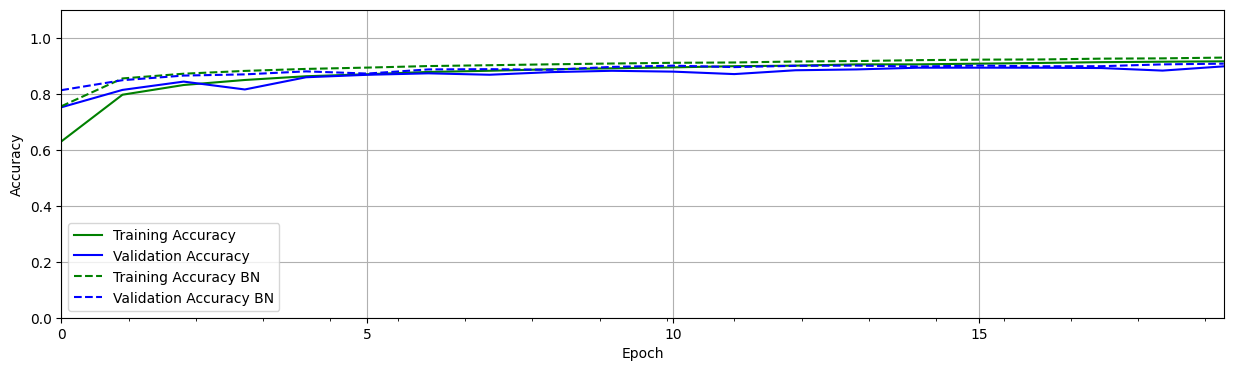

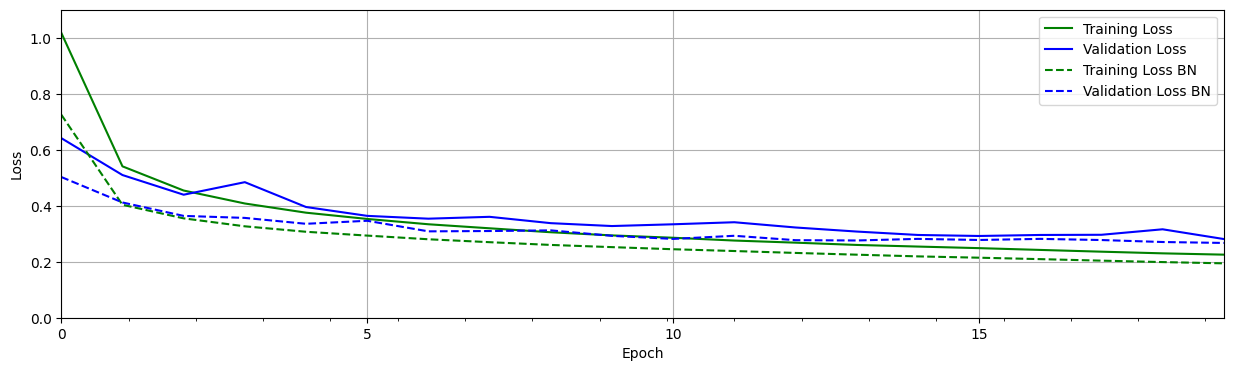

In [ ]:
# Retrieve training results.
train_loss = history["train_loss"]
train_acc  = history["train_acc"]
train_loss_bn = history_batch_norm["train_loss"]
train_acc_bn  = history_batch_norm["train_acc"]

valid_loss = history["valid_loss"]
valid_acc  = history["valid_acc"]
valid_loss_bn = history_batch_norm["valid_loss"]
valid_acc_bn = history_batch_norm["valid_acc"]


train_config = history["train_config"]
    
plot_results([ train_acc, valid_acc, train_acc_bn, valid_acc_bn], 
            ylabel="Accuracy",
            ylim = [0.0, 1.1],
            metric_name=["Training Accuracy", "Validation Accuracy",
                         "Training Accuracy BN", "Validation Accuracy BN"],
            color=["g", "b"],
            training_config=train_config)

plot_results([ train_loss, valid_loss, train_loss_bn, valid_loss_bn],        
            ylabel="Loss", 
            ylim = [0.0, 1.1],
            metric_name=["Training Loss", "Validation Loss",
                         "Training Loss BN", "Validation Loss BN"],
            color=["g", "b"],
            training_config=train_config);

## 7 Plot Predictions

The `prediction_batch` function takes in the trained model and returns the class index having the highest logits. This is performed on the entire image batch.

In [ ]:
def prediction_batch(model: nn.Module, batch_inputs: torch.tensor):
    
    model.eval()
    
    with torch.no_grad():
        batch_logits = model(batch_inputs)
    
    batch_cls_ids = batch_logits.argmax(dim=1)
    
    return batch_cls_ids.cpu()

The `visualize_image_predictions` helper function is used to plot the predicted confidence scores and class indices along with target class labels. It takes in the following arguments:

- `image_batch`: The image batch to be plotted. 

- `preds_batch`: The batched predictions. Each item in `preds_batch` comprises of the predicted **label**.

- `classes`: The list of classes in the dataset.

- `total_samples`: The total number of samples that we want to plot.

In [ ]:
def visualize_image_predictions(
    image_batch: torch.tensor,
    preds_batch: torch.tensor,
    target_batch: torch.tensor,
    classes: List[str],
    total_samples: int,
   ):
    
    num_cols = 5
    num_rows = math.ceil(total_samples/num_cols)  
    
    font_format = {
                    "family": "sans-serif",
                    'size': 18,
                  }
    
    fig = plt.figure(figsize=(24, 18))
    
    for i, (image, pred, target) in enumerate(zip(image_batch, preds_batch, target_batch)):
        
        image_np = image.squeeze().numpy()
        
        if pred==target:
            title_color = "g"
        else:
            title_color = "r"
        
        ax = plt.subplot(num_rows, num_cols, i+1)
        title = f"Tar: {classes[int(target)]}, Pred: {classes[int(pred)]}"
        title_obj = plt.title(title, fontdict=font_format)
        plt.setp(title_obj, color=title_color)
        plt.axis("off")
        plt.imshow(image_np, cmap="gray")
   
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()   
    plt.close()
    return

The `plot_predictions` helper function takes in the trained model and the dataloader to visualize the predictions on a few test samples. It takes in the following arguments:

- `model`: The trained model.

- `data_loader`: The dataloader for which we want to display the samples.

- `device`: The device on which to perform inference.

In [ ]:
def plot_predictions(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: str = "cpu",
    ):
    
    model = model.to(device)
    
    class_names = data_loader.dataset.classes
    
    random.seed(21)
    num_rows = 4
    num_cols = 5
    num_data = num_rows*num_cols
    shuffled_indices = random.sample(range(len(data_loader.dataset)), num_data)

    image_batch = []
    targets_batch = []

    for idx in shuffled_indices:
        image_trans, target = data_loader.dataset[idx]
        image_batch.append(image_trans)
        targets_batch.append(target)
        
    image_batch = torch.stack(image_batch).to(device) 
    targets_batch = torch.tensor(targets_batch)
    
    preds_batch = prediction_batch(model, image_batch)
    
    visualize_image_predictions(
                    image_batch.cpu(),
                    preds_batch,
                    targets_batch,
                    class_names,
                    num_data,
                  )
          
    return

Let's prepare our dataloader along with the required transformations.

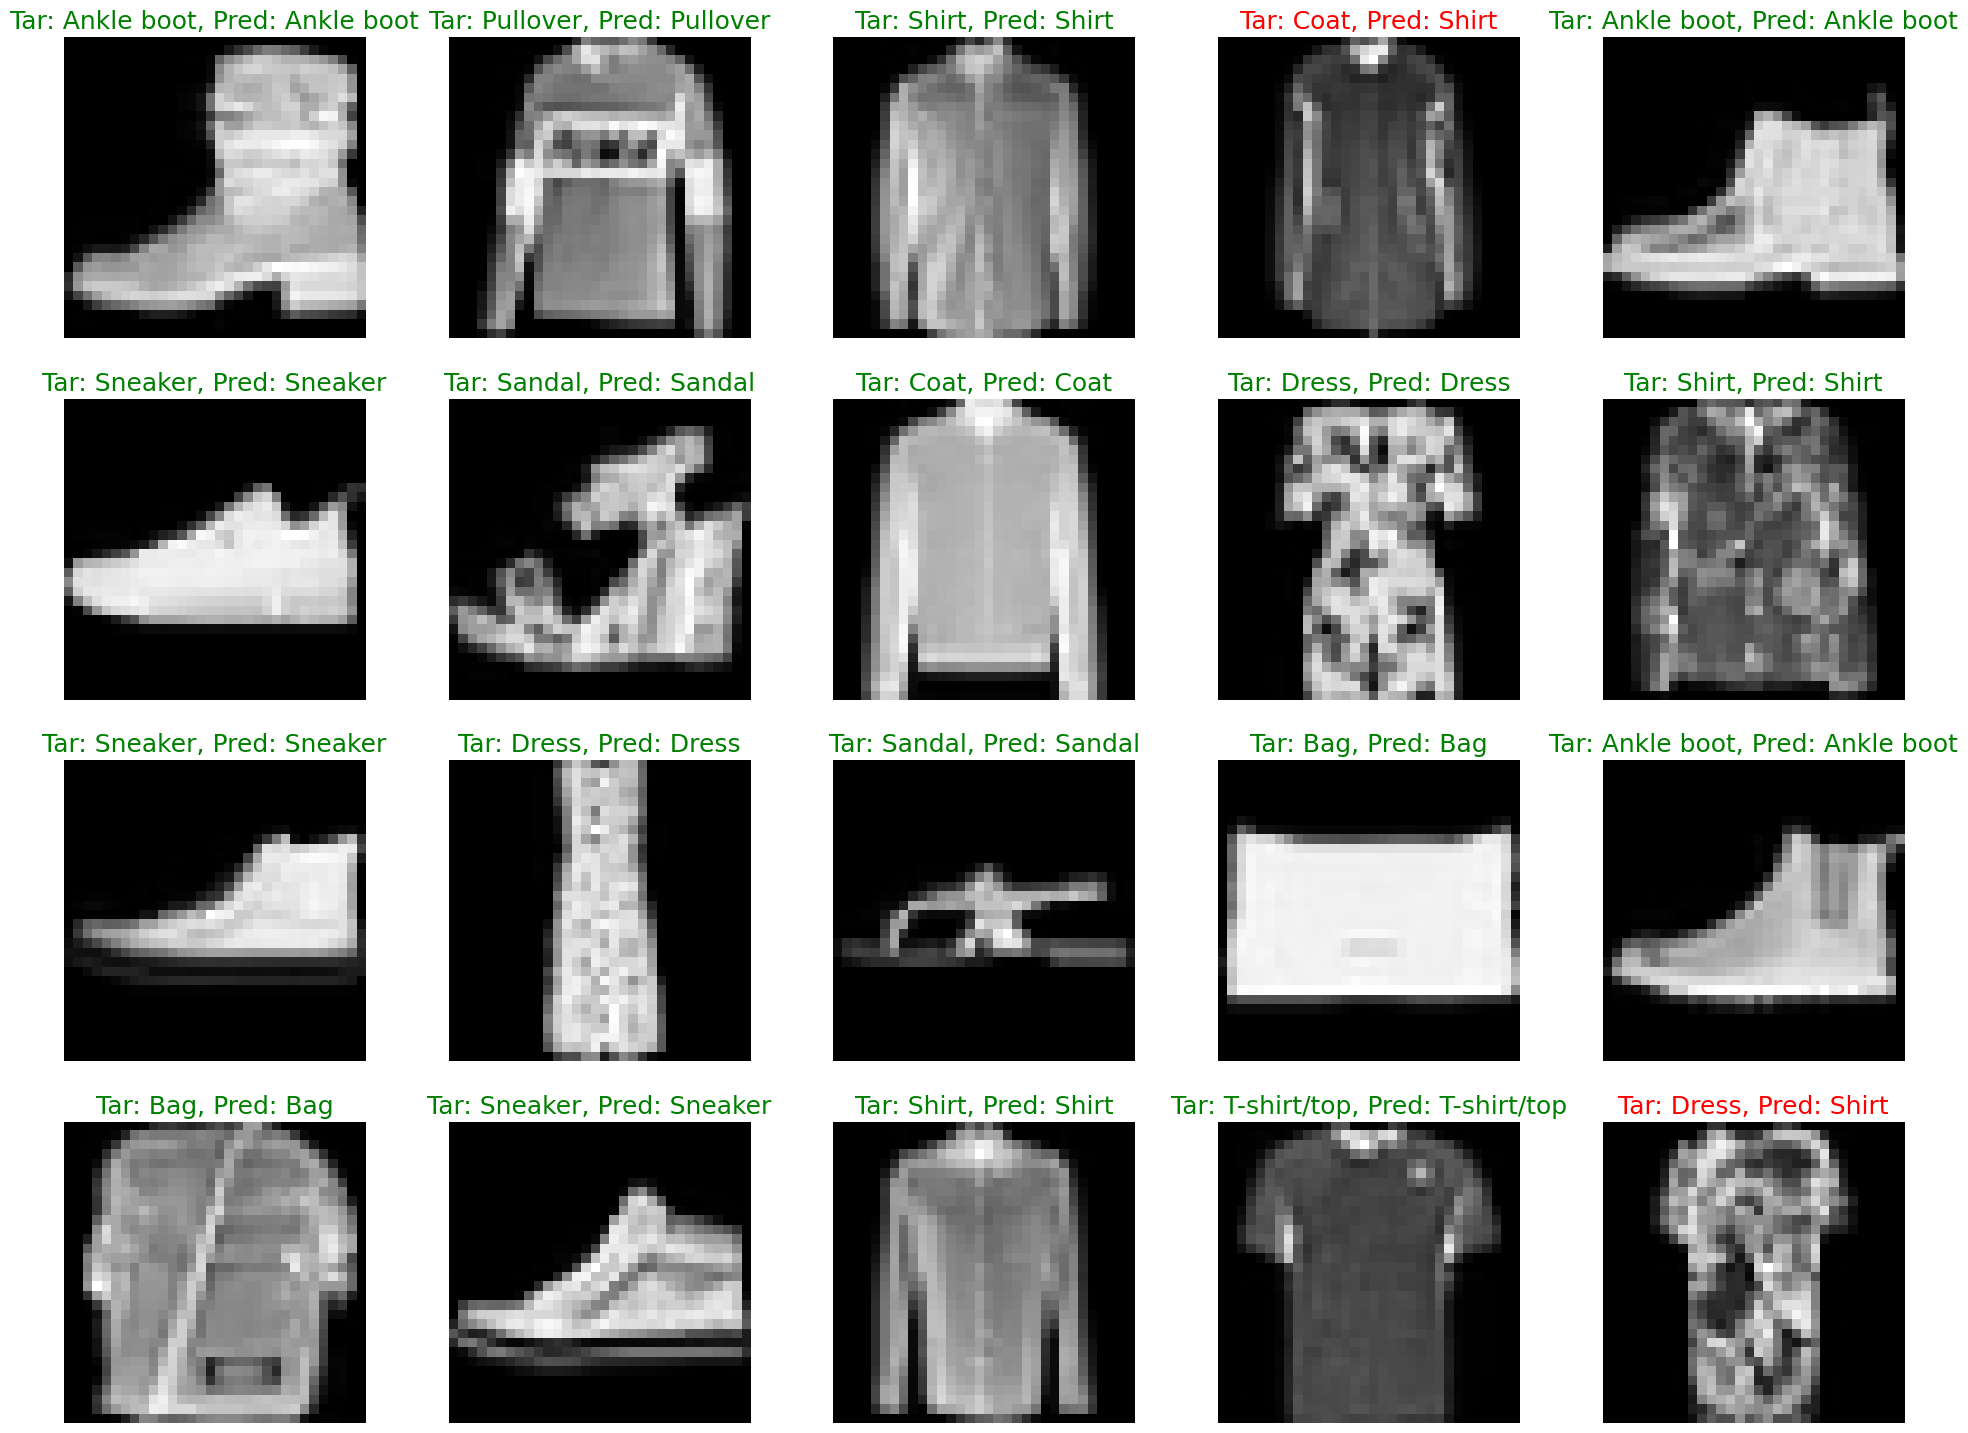

In [ ]:
trained_model = history_batch_norm["model"]
dataset_config = history_batch_norm["data_config"]

_, test_loader = get_data(
                        root_dir=dataset_config.DATA_ROOT,
                        img_size=(dataset_config.IMG_HEIGHT, dataset_config.IMG_WIDTH),
                        batch_size=dataset_config.BATCH_SIZE,
                        num_workers=dataset_config.NUM_WORKERS
                     )


plot_predictions(trained_model, test_loader, train_config.DEVICE)

## 7 Conclusion

In this notebook, we have seen how Batch Norm helps the model's weights converge faster yiels slightly better training and validation loss. It is very interesting to note that majority of the State of the Art (SOTA) classification models use Batch Norm in their networks.